In [1]:
!git clone https://github.com/salesforce/PCL.git
%cd PCL



Cloning into 'PCL'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 160 (delta 18), reused 12 (delta 12), pack-reused 134 (from 2)
Receiving objects: 100% (160/160), 196.36 KiB | 15.10 MiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/PCL


In [2]:
!pip install torch torchvision
!pip install numpy tqdm pyyaml

In [3]:
#install densenet
!pip install timm


In [4]:
import torch
print(torch.cuda.is_available())  # True
print(torch.cuda.get_device_name(0))  #GPU name

True
Tesla T4


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
DATASET_PATH = "/content/drive/My Drive/dataset_cropped"

In [7]:
%cd /content/PCL


/content/PCL


In [8]:
!pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 33.7 MB/s eta 0:00:00


In [9]:
import torch
import torch.nn as nn

In [10]:
import importlib
import sys
import pcl.builder as builder

# Print where the module is loaded from
print("Reloaded from:", builder.__file__)

# Force reload and confirm
builder = importlib.reload(builder)
print("After reload:", builder.__file__)

# Check if MoCo exists
print("MoCo available?", hasattr(builder, "MoCo"))

# Print id to confirm new module object
print("Module id:", id(builder))


Reloaded from: /content/PCL/pcl/builder.py
After reload: /content/PCL/pcl/builder.py
MoCo available? True
Module id: 139330619171168


In [11]:
import sys
sys.path.insert(0, "/content/PCL")  # force project path

from pcl import builder
print("Builder path:", builder.__file__)
print("Has MoCo:", hasattr(builder, "MoCo"))


Builder path: /content/PCL/pcl/builder.py
Has MoCo: True


In [12]:
import os, sys
sys.path.append('/content/PCL')

from pcl import builder
print("✅ Import worked!")

import sys
sys.path.insert(0, "/content/PCL")


✅ Import worked!


In [ ]:
%reset -f

In [ ]:
builder_path = "/content/PCL/pcl/builder.py"

# Read builder.py
with open(builder_path, "r") as f:
    original_code = f.read()

# Ensure imports exist
imports_to_add = []
if "import timm" not in original_code:
    imports_to_add.append("import timm")
if "import torch" not in original_code:
    imports_to_add.append("import torch")
if "import torch.nn as nn" not in original_code:
    imports_to_add.append("import torch.nn as nn")

# Only add MoCo if it's not already defined
if "class MoCo" not in original_code:
    moco_code = """

class MoCo(nn.Module):
    def __init__(self, base_encoder=None, dim=128, r=16384, m=0.999, T=0.1, mlp=False):
        super(MoCo, self).__init__()
        self.r = r
        self.T = T
        self.m = m

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Query & key encoders (DenseNet-121 backbone from timm)
        self.encoder_q = timm.create_model("densenet121", pretrained=True, num_classes=dim).to(self.device)
        self.encoder_k = timm.create_model("densenet121", pretrained=True, num_classes=dim).to(self.device)

        # Optionally replace classifier with MLP head
        if mlp:
            dim_mlp = self.encoder_q.classifier.in_features
            self.encoder_q.classifier = nn.Sequential(
                nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), nn.Linear(dim_mlp, dim)
            )
            self.encoder_k.classifier = nn.Sequential(
                nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), nn.Linear(dim_mlp, dim)
            )

        # initialize key encoder to be the same as query encoder, and freeze it
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

        # queue for negative samples
        self.register_buffer("queue", torch.randn(dim, r))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        keys = concat_all_gather(keys)
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)
        assert self.r % batch_size == 0, "Queue size must be divisible by batch size"
        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.r
        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _batch_shuffle_ddp(self, x):
        idx_unshuffle = None
        return x, idx_unshuffle

    @torch.no_grad()
    def _batch_unshuffle_ddp(self, x, idx_unshuffle):
        return x



    def forward(self, im_q, im_k=None, is_eval=False, cluster_result=None, index=None):
        im_q = im_q.to(self.device)
        if im_k is not None:
            im_k = im_k.to(self.device)
        if index is not None:
            index = index.to(self.device)

        # ----- Normal MoCo forward -----
        if is_eval:
            self.encoder_k.eval()
            k = self.encoder_k(im_q)
            k = nn.functional.normalize(k, dim=1)
            return k

        with torch.no_grad():
            self._momentum_update_key_encoder()
            im_k, idx_unshuffle = self._batch_shuffle_ddp(im_k)
            k = self.encoder_k(im_k)
            k = nn.functional.normalize(k, dim=1)
            k = self._batch_unshuffle_ddp(k, idx_unshuffle)

        q = self.encoder_q(im_q)
        q = nn.functional.normalize(q, dim=1)

        # contrastive logits
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach().to(self.device)])
        logits = torch.cat([l_pos, l_neg], dim=1)
        logits /= self.T
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.device)

        self._dequeue_and_enqueue(k)

        # ----- PCL extension -----
        output_proto, target_proto = None, None
        if cluster_result is not None:
            im2cluster = cluster_result['im2cluster']
            if not torch.is_tensor(im2cluster):
                im2cluster = torch.tensor(im2cluster, dtype=torch.long, device=self.device)
            else:
                im2cluster = im2cluster.to(self.device)

            proto_labels = im2cluster[index]
            output_proto = q
            target_proto = proto_labels

        return logits, labels, output_proto, target_proto


    @torch.no_grad()
    def concat_all_gather(tensor):
        return tensor


"""

    # Add missing imports + MoCo
    with open(builder_path, "a") as f:
        if imports_to_add:
            f.write("\n" + "\n".join(imports_to_add) + "\n")
        f.write("\n" + moco_code)

print("MoCo class with densenet121 backbone appended to builder.py")

MoCo class with densenet121 backbone appended to builder.py


In [13]:
import sys
sys.path.insert(0, "/content/PCL")

from pcl import builder
print("MoCo available?", hasattr(builder, "MoCo"))


MoCo available? True


In [14]:
import timm
print([m for m in timm.list_models() if "densenet" in m])


['densenet121', 'densenet161', 'densenet169', 'densenet201', 'densenet264d', 'densenetblur121d']


In [19]:
!python3 /content/PCL/main_pcl.py \
  "/content/drive/My Drive/dataset_cropped" \
  --arch densenet121 \
  --epochs 300 \
  --batch-size 32 \
  --lr 0.0005 \
  --temperature 0.2 \
  --num-cluster 3

Streaming output truncated to the last 5000 lines.
Outer iteration 3 / 5
  Iteration 19 (0.00 s, search 0.00 s): objective=1413.42 imbalance=1.019 nsplit=0       
Objective improved: keep new clusters
Outer iteration 4 / 5
  Iteration 19 (0.01 s, search 0.01 s): objective=1416.06 imbalance=1.009 nsplit=0       
Epoch: [39][0/8]	Time  6.454 ( 6.454)	Data  5.767 ( 5.767)	Loss 8.4200e+00 (8.4200e+00)	Acc@Inst   3.12 (  3.12)	Acc@Proto   0.00 (  0.00)
[DEBUG] Epoch 40 | warmup_epoch = 0 | Clustering will run: True
Computing features...
100% 2/2 [00:07<00:00,  3.51s/it]
performing kmeans clustering
Clustering 279 points in 128D to 3 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (0.00 s, search 0.00 s): objective=1462.81 imbalance=1.258 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (0.00 s, search 0.00 s): objective=1445.38 imbalance=1.023 nsplit=0       
Objective improved: keep new clusters


Using checkpoint: /content/PCL/experiment_pcl/checkpoint_0299.pth.tar


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


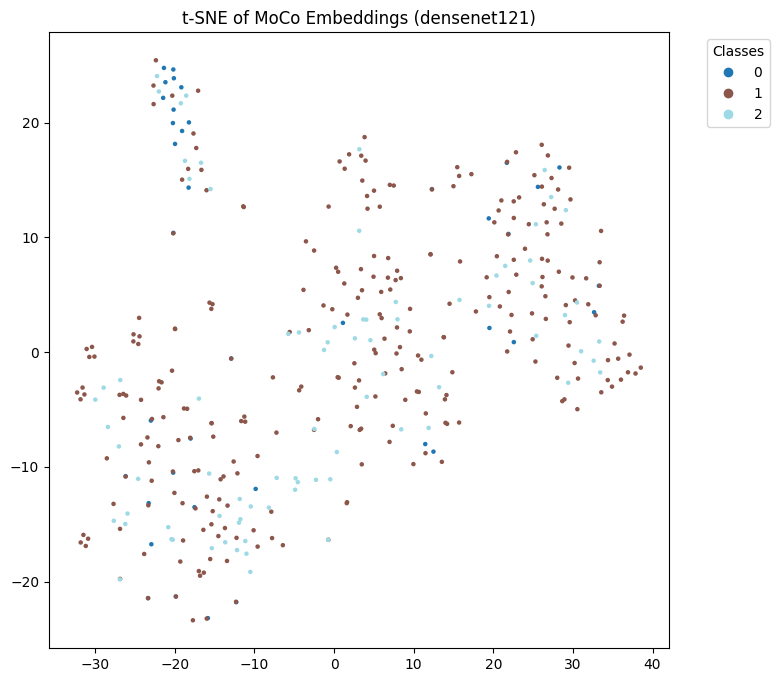

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


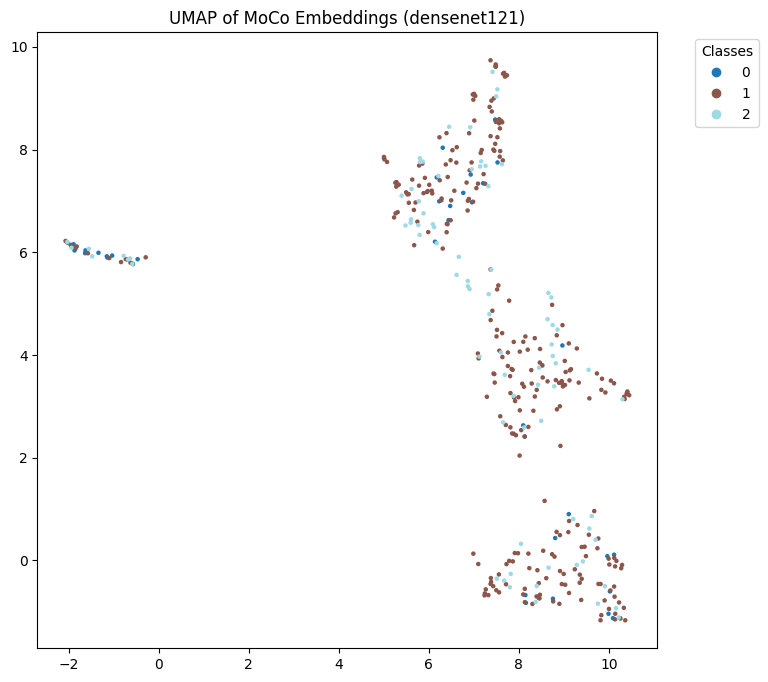

NMI: 0.1872
ARI: 0.0005
Silhouette Score: -0.0065


In [20]:
# --- Install dependencies ---
!pip install timm faiss-cpu umap-learn scikit-learn matplotlib

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score
import numpy as np
import umap
import glob
import timm
from pcl import builder
import torch.nn as nn

# --- Find latest checkpoint ---
checkpoints = sorted(glob.glob("/content/PCL/experiment_pcl/checkpoint_*.pth.tar"))
checkpoint_path = checkpoints[-1]  # latest checkpoint
print("Using checkpoint:", checkpoint_path)



# --- Manually set args used in training ---
arch = "densenet121"  # timm model
low_dim = 128
pcl_r = 4
moco_m = 0.999
temperature = 0.2
mlp = True


# --- Build MoCo model with timm backbone ---
class DenseNetWrapper(nn.Module):
    def __init__(self, backbone, out_dim=128):
        super().__init__()
        self.backbone = backbone

        # detect feature dimension
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            feat = self.forward_features(dummy)
            self.out_dim = feat.shape[1]

        # IMPORTANT: always a Linear (not Identity), so MoCo can use .weight
        self.fc = nn.Linear(self.out_dim, out_dim)

    def forward_features(self, x):
        x = self.backbone.forward_features(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1)).flatten(1)
        return x

    def forward(self, x, **kwargs):
        x = self.forward_features(x)
        return x


def get_densenet121(num_classes=128, **kwargs):
    backbone = timm.create_model("densenet121", pretrained=True, num_classes=0)
    return DenseNetWrapper(backbone, out_dim=num_classes)


# --- Pass the callable, not an instance ---
model = builder.MoCo(
    get_densenet121,  # function
    low_dim,
    pcl_r,
    moco_m,
    temperature,
    mlp
)

# --- Load checkpoint but remove queue ---
ckpt = torch.load(checkpoint_path, map_location="cpu")
state_dict = {k: v for k, v in ckpt['state_dict'].items() if not k.startswith('queue')}
model.load_state_dict(state_dict, strict=False)
model.eval().cuda()

# --- Dataset & DataLoader ---
data_path = "/content/drive/MyDrive/dataset_cropped"
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(data_path, transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

# --- Feature extraction ---
all_features = []
all_labels = []

with torch.no_grad():
    for imgs, labels in loader:
        imgs = imgs.cuda(non_blocking=True)
        feats = model.encoder_q(imgs)   # forward through MoCo encoder
        if isinstance(feats, (tuple, list)):  # timm models sometimes return (feats, aux)
            feats = feats[0]
        feats = torch.nn.functional.normalize(feats, dim=1)
        all_features.append(feats.cpu())
        all_labels.append(labels)

all_features = torch.cat(all_features, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# --- t-SNE Visualization ---
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_embeds = tsne.fit_transform(all_features)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(tsne_embeds[:, 0], tsne_embeds[:, 1], c=all_labels, cmap="tab20", s=5)
plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE of MoCo Embeddings (densenet121)")
plt.show()

# --- UMAP Visualization ---
umap_embeds = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(all_features)
plt.figure(figsize=(8, 8))
scatter = plt.scatter(umap_embeds[:, 0], umap_embeds[:, 1], c=all_labels, cmap="tab20", s=5)
plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("UMAP of MoCo Embeddings (densenet121)")
plt.show()

# --- Clustering Metrics ---
# Simple nearest-neighbor pseudo clustering
sim_matrix = all_features @ all_features.T
np.fill_diagonal(sim_matrix, -1)   # ignore self
nearest_idx = np.argmax(sim_matrix, axis=1)

nmi = normalized_mutual_info_score(all_labels, nearest_idx)
ari = adjusted_rand_score(all_labels, nearest_idx)
sil = silhouette_score(all_features, all_labels)

print(f"NMI: {nmi:.4f}")
print(f"ARI: {ari:.4f}")
print(f"Silhouette Score: {sil:.4f}")


In [21]:
# -------------------------------
# Install timm for densenet
# -------------------------------
!pip install timm

import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import glob
import timm
from pcl import builder   # your MoCo builder

# -------------------------------
# Load latest checkpoint
# -------------------------------
checkpoints = sorted(glob.glob("/content/PCL/experiment_pcl/checkpoint_*.pth.tar"))
checkpoint_path = checkpoints[-1]
print("Using checkpoint:", checkpoint_path)

# --- Load checkpoint but remove queue ---
ckpt = torch.load(checkpoint_path, map_location="cpu")
state_dict = {k: v for k, v in ckpt['state_dict'].items() if not k.startswith('queue')}
model.load_state_dict(state_dict, strict=False)
model.eval().cuda()

# -------------------------------
# Dataset & DataLoader
# -------------------------------
train_dir = "/content/drive/My Drive/dataset_cropped/train"
test_dir  = "/content/drive/My Drive/dataset_cropped/test"

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

# -------------------------------
# Feature Extraction
# -------------------------------
def extract_features(dataloader):
    features, labels = [], []
    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.cuda(non_blocking=True)
            feats = model.encoder_q(imgs)
            if isinstance(feats, (tuple, list)):  # timm sometimes returns tuple
                feats = feats[0]
            feats = F.normalize(feats, dim=1)
            features.append(feats.cpu())
            labels.append(lbls)
    return torch.cat(features), torch.cat(labels)

train_features, train_labels = extract_features(train_loader)
test_features, test_labels   = extract_features(test_loader)

# -------------------------------
# Centroid-based Classification
# -------------------------------
def compute_centroids(features, labels, num_classes):
    centroids = []
    for c in range(num_classes):
        mask = labels == c
        class_feats = features[mask]
        centroid = class_feats.mean(dim=0)
        centroids.append(centroid)
    return torch.stack(centroids)

num_classes = len(train_dataset.classes)
centroids = compute_centroids(train_features, train_labels, num_classes)
centroids = F.normalize(centroids, dim=1)

def predict_with_centroids(test_feats, centroids):
    sims = test_feats @ centroids.T
    preds = torch.argmax(sims, dim=1)
    return preds

pred_labels = predict_with_centroids(test_features, centroids)

# -------------------------------
# Evaluation Metrics
# -------------------------------
y_true = test_labels.numpy()
y_pred = pred_labels.numpy()

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")  # Sensitivity
f1 = f1_score(y_true, y_pred, average="macro")

# Specificity per class
cm = confusion_matrix(y_true, y_pred)
specificity = []
for i in range(num_classes):
    tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
    fp = cm[:,i].sum() - cm[i,i]
    specificity.append(tn / (tn + fp))
specificity = np.mean(specificity)

# -------------------------------
# Print Results
# -------------------------------
print("Confusion Matrix:\n", cm)
print(f"Accuracy:     {acc:.16f}")
print(f"Precision:    {precision:.16f}")
print(f"Sensitivity:  {recall:.16f}")
print(f"F1 Score:     {f1:.16f}")
print(f"Specificity:  {specificity:.16f}")


Using checkpoint: /content/PCL/experiment_pcl/checkpoint_0299.pth.tar
Train size: 279
Test size: 39


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion Matrix:
 [[10  2  1]
 [ 0 12  1]
 [ 0  0 13]]
Accuracy:     0.8974358974358975
Precision:    0.9079365079365079
Sensitivity:  0.8974358974358975
F1 Score:     0.8956751782838740
Specificity:  0.9487179487179488
